## Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('application_train.csv')

In [3]:
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Initial look at dataset

### How many defaults in the dataset?

In [4]:
value_counts_target = df.TARGET.value_counts()
value_counts_target[1] / value_counts_target[0]

0.08781828601345662

### What is each row in applications? A credit or a person or a group of persons?

In [5]:
# count rows per ID
counted_by_id = df.groupby('SK_ID_CURR').count()
counted_by_id

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
100003,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
100004,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
100006,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,0,0,0,0
100007,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,0,0,0,0
456252,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,0,0,0,0
456253,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [6]:
# see whether there is a ID that has more than one value for a variable 
identifier = counted_by_id[counted_by_id > 1].aggregate(sum)

print(identifier[identifier == 1])

Series([], dtype: float64)


There are no IDs that have more than one value. 
The dataset's IDs are unique row identifiers.
Couple/Partnership credits only have one row.
Identification of partnership credits through NAME_TYPE_SUITE?

## Transform variables assigned

### Categorical variables

#### EDUCATION TYPE

In [7]:
# check all categories and their counts
df.NAME_EDUCATION_TYPE.value_counts()

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64

Looking at the education types of the creditor.
There are 5 education levels defined in the variable, namely:
- Secondary / secondary special
- Higher education
- Incomplete higher
- Lower secondary
- Academic degree

Approach is to make this into a binary variable that identifies higher and lower education.
Remark would be that there are people that have attended higher education, but have not graduated, these people will be assigned to the higher education group


In [8]:
# make new variables higher education
df_lennard = pd.DataFrame(df['SK_ID_CURR'].copy())

lower_edu_index = (df.NAME_EDUCATION_TYPE == 'Secondary / secondary special') | (df.NAME_EDUCATION_TYPE == 'Lower secondary')
df_lennard['HIGHER_EDUCATION'] = 1
df_lennard['HIGHER_EDUCATION'][lower_edu_index] = 0

# check whether variable was correctly created
df_lennard['HIGHER_EDUCATION'].value_counts()

0    222207
1     85304
Name: HIGHER_EDUCATION, dtype: int64

### Continuous variables

#### Heatmap of chosen continous variables

In [11]:
continuous_features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'AMT_ANNUITY', 'CNT_FAM_MEMBERS']

categorical_features = []

X = df[continuous_features + categorical_features]

y = df['TARGET']

<AxesSubplot: >

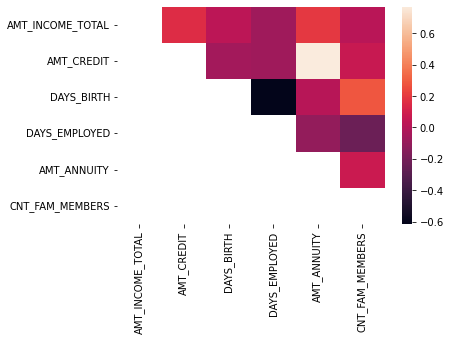

In [12]:
corrs = df[continuous_features].corr()

half_corrs = np.tril(corrs)

sns.heatmap(corrs, mask=half_corrs)

#### DAYS EMPLOYED

In [ ]:
days_employed = np.abs(df.DAYS_EMPLOYED.copy())
# winsorize at 99 percentile
ninenine = np.quantile(days_employed, q = .81)
days_employed = [ninenine if x >= ninenine else x for x in days_employed]

plt.hist(days_employed)
plt.show()

We decided to drop days employment for the baseline model.
Reason being that there are more than 15% of the observations that say persons have been employed ~1000 years.
Clearly this is some kind of error.
Since age of the person and the employment correlate heavily, we decided to only take in the age, which does not show this kind of error.

In [ ]:
df_lennard['days_employed_winsorized'] = days_employed

## Modelling

In [ ]:
cth = ColumnTransformer(
    [
        (
            "binned", KBinsDiscretizer(n_bins = 4, encode = 'ordinal'), 
            ['']),
        (
            "minmaxed", MinMaxScaler(), 
            ['']),
        (
            "onehots", OneHotEncoder(),
            []),
        (
            "passthroughs", 'passthrough', 
            ['HIGHER_EDUCATION'])
    ])

In [ ]:
accuracies = []
model = []

kf = KFold(n_splits=10)
kf.get_n_splits(features)

for train_index, test_index in kf.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    
    model.append(lr)
    accuracies.append(accuracy_score(predictions, y_test))
    
index = (accuracies == np.max(accuracies))
    

In [ ]:
print('The best model has accuracy of: ', accuracies[index])
print('Coeficients are: ', model[index].coef_)